# 実践プログラミング: Identiconの生成

## Images.jl パッケージ

Julia には画像処理パッケージとして Images.jl がある

まずは、これをインストールして使ってみる

In [1]:
using Pkg

# パッケージインストール時のメッセージ出力先を stdout (Jupyter Cell) に変更
Pkg.DEFAULT_IO[] = stdout

# Images.jl, ImageMagick.jl パッケージインストール
Pkg.add("Images")
Pkg.add("ImageMagick")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/github/julia_ml-tuto/Project.toml`
  No Changes to `~/github/julia_ml-tuto/Manifest.toml`
   Resolving package versions...
  No Changes to `~/github/julia_ml-tuto/Project.toml`
  No Changes to `~/github/julia_ml-tuto/Manifest.toml`


In [2]:
using Images

Gray(0.0) # black

In [3]:
RGB(0.0, 0.0, 1.0) # blue

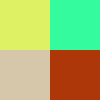

In [4]:
# Images, ImageMagickパッケージを使っている場合、Vector{RGB{Float64}}はRGBピクセルを表示する
img_rgb = rand(RGB, 2, 2)

In [5]:
println(img_rgb)

RGB{Float64}[RGB{Float64}(0.8705312249552608,0.9392807117526314,0.3898327653899909) RGB{Float64}(0.20546251032559049,0.983952742325525,0.6203124861433165); RGB{Float64}(0.8379977141117236,0.7797811557579499,0.6666087403658305) RGB{Float64}(0.6766564027360429,0.21411864315113238,0.035485618891520465)]


## Identiconの生成

参考: [GitHubのIdenticonの生成と取得](https://qiita.com/pira/items/dd4057ef499154968f69#%E3%83%97%E3%83%AD%E3%83%95%E3%82%A3%E3%83%BC%E3%83%AB%E7%94%BB%E5%83%8F%E3%81%AE%E6%88%BB%E3%81%97%E6%96%B9)

### Identiconとは
GitHubアカウントを作成したときにプロフィール画像になってるドット絵アイコン

自分のIdenticonは `https://github.com/identicons/<username>.png` から確認できる

![amenoyoya.png](https://github.com/identicons/amenoyoya.png)

### Identiconの生成方法
GitHubのBlogにIdenticonの生成に関する記事があるようである

[Identicons!](https://github.com/blog/1586-identicons) - The GitHub Blog

記事によると、Identiconは5x5のピクセルで、ユーザーIDのハッシュ値を元に以下のように生成されているそうである

- ハッシュ値が偶数か奇数かで各ピクセルのon/offを決定してパターンを生成
- Identiconの色も同様にハッシュ値に依存して決定している
    - これによって多数のユニークなIdenticonsを保証している

### Identiconを生成

#### ハッシュ値の生成
ユーザーIDをMD5に変換する

なお、GitHubのユーザ名からユーザIDを取得するには、[Find GitHub User ID](https://caius.github.io/github_id/) を使うと良い

ユーザーIDをMD5に変換すると、128bit（16進数で32桁）のハッシュ値が得られる

ex) 46098475 -> da9701f509fd65331303f9382088b168

#### パターンの決定
パターンは以下のように、5x5のピクセルから成る

![identicon00.png](./img/identicon00.png)

ハッシュ値の前から15文字を使って以下のようにパターンを決定する

- ハッシュ値が偶数ならピクセルをON，奇数ならピクセルをOFFにする
- 順番は真ん中の列の上から下、その右の列の上から下、最後に右端の列の上から下の順とする

ex) da9701f509fd65331303f9382088b168 -> da9701f509fd653

![identicon01.png](./img/identicon01.png)

以下のように、真ん中の列を中心に線対称に折り返す

![identicon02.png](./img/identicon02.png)

これでパターンが完成する

#### 色の決定
ハッシュ値の最後の7文字を使って色を決定する

色はHSL色空間で表現されており、色相3文字、彩度2文字、輝度2文字で決定する

ex) da9701f509fd65331303f9382088b168 -> 088b168 -> 色相: 088, 彩度: b1, 輝度: 68

各16進数を10進数に変換して各パラメータを決定する

色相は0から360の範囲であるため、0(0x000)〜4095(0xfff)を0〜360の範囲に変換する

同様に、彩度と輝度は、0(0x00)〜255(0xff)を0から100の範囲に変換する

GitHubでは0〜255を0〜20の範囲に変換して、それぞれ65, 75から減算した値を使用している

$$ \begin{array}{ll}
    色相: (cbc)_{10} \times \frac{360}{4095} &= 3260 \times \frac{360}{4095} \\
                                             &= 287 \\
    彩度: 65−(db)_{10} \times \frac{20}{255} &= 65−219 \times \frac{20}{255} \\
                                             &= 48 \\
    輝度: 75−(ac)_{10} \times \frac{20}{255} &= 75−172 \times \frac{20}{255}
\end{array} $$

最後にHSL色空間からRGBへ変換し、Identiconの完成となる

In [6]:
# ハッシュ、暗号化ラッパーパッケージ Nettle.jl インストール
Pkg.add("Nettle");

   Resolving package versions...
  No Changes to `~/github/julia_ml-tuto/Project.toml`
  No Changes to `~/github/julia_ml-tuto/Manifest.toml`


In [7]:
using Nettle

# GitHubユーザID
myid = "46098475"

# md5ハッシュ値算出
md5 = hexdigest("md5", myid)

"da9701f509fd65331303f9382088b168"

In [8]:
# ハッシュ値の前から15文字を16進数→10進数に変換
pat = [parse(Int, hash; base=16) for hash in md5[1:15]]

15-element Vector{Int64}:
 13
 10
  9
  7
  0
  1
 15
  5
  0
  9
 15
 13
  6
  5
  3

In [9]:
# 5 x 3 Array{Int,2} に変形
pat = reshape(pat, 5, 3)

5×3 Matrix{Int64}:
 13   1  15
 10  15  13
  9   5   6
  7   0   5
  0   9   3

In [10]:
# ハッシュ値を偶数・奇数に変換: 0をONとする
pat = pat .% 2

5×3 Matrix{Int64}:
 1  1  1
 0  1  1
 1  1  0
 1  0  1
 0  1  1

In [11]:
# 行列を線対称にする
## 水平結合: pat[3..2列目]のパターン + patのパターン
pat = hcat(pat[:, 3:-1:2], pat)

5×5 Matrix{Int64}:
 1  1  1  1  1
 1  1  0  1  1
 0  1  1  1  0
 1  0  1  0  1
 1  1  0  1  1

In [12]:
"""
色相の算出
"""
# ハッシュ値の後ろから7文字目の部分から3文字分を取得し、16進数→10進数に変換
hue = md5[end-6:end-4]
hue = parse(Int, hue; base=16)

136

In [13]:
# 色相 = (md[-7..-5])_10 * 360 / 4095
hue = hue * 360 / 4095

11.956043956043956

In [14]:
# 彩度 = 65 - (md[-4..-3])_10 * 20 / 255
saturation = 65 - parse(Int, md5[end-3:end-2]; base=16) * 20 / 255

51.11764705882353

In [15]:
# 輝度 = 75 - (md[-2..-1])_10 * 20 / 255
luminance = 75 - parse(Int, md5[end-1:end]; base=16) * 20 / 255

66.84313725490196

In [16]:
# HSV→RGB変換関数
## 色相, 彩度, 輝度 -> (R, G, B)::Tuple{Int,Int,Int}
hsv2rgb(hue::Number, sat::Number, lum::Number)::Tuple{Int,Int,Int} = begin
    max, min = if lum < 50
        # 輝度が50未満の場合
        2.55 * (lum + lum * (sat/100)),
        2.55 * (lum - lum * (sat/100))
    else
        # 輝度が50以上の場合
        2.55 * (lum + (100-lum) * (sat/100)),
        2.55 * (lum - (100-lum) * (sat/100))
    end
    
    # 色相ごとにRGB計算を分岐
    r, g, b = if hue < 60
        max, (hue/60) * (max-min) + min, min
    elseif 60 <= hue < 120
        ((120-hue)/60) * (max-min) + min, max, min
    elseif 120 <= hue < 179
        min, max, ((hue-120)/60) * (max-min) + min
    elseif 180 <= hue < 240
        min, ((240-hue)/60) * (max-min) + min, max
    elseif 240 <= hue < 300
        ((hue-240)/60) * (max-min) + min, min, max
    else
        max, min, ((360-hue)/60) * (max-min) + min
    end
    (Int(floor(r)), Int(floor(g)), Int(floor(b)))
end

hsv2rgb (generic function with 1 method)

In [17]:
color = hsv2rgb(hue, saturation, luminance)

(213, 144, 127)

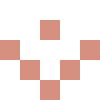

In [18]:
# 作成したパターンのうち、0の部分を着色する
image = zeros(RGB, size(pat)[1], size(pat)[2])

for y in 1:size(pat)[1], x in 1:size(pat)[2]
    image[y, x] = pat[y, x] == 0 ? RGB(color[1]/255, color[2]/255, color[3]/255) : RGB(1.0, 1.0, 1.0)
end

image

In [19]:
"""
完成形
"""

using Nettle
using Images

# idからIdenticon生成
make_identicon(id::String) = begin
    md5 = hexdigest("md5", id)
    pat = [parse(Int, hash; base=16) for hash in md5[1:15]]
    pat = reshape(pat .% 2, 5, 3)
    pat = hcat(pat[:, 3:-1:2], pat)
    hue = parse(Int, md5[end-6:end-4]; base=16) * 360 / 4095
    sat = 65 - parse(Int, md5[end-3:end-2]; base=16) * 20 / 255
    lum = 75 - parse(Int, md5[end-1:end]; base=16) * 20 / 255
    
    max, min = if lum < 50
        2.55 * (lum + lum * (sat/100)),
        2.55 * (lum - lum * (sat/100))
    else
        2.55 * (lum + (100-lum) * (sat/100)),
        2.55 * (lum - (100-lum) * (sat/100))
    end
    
    r, g, b = if hue < 60
        max, (hue/60) * (max-min) + min, min
    elseif 60 <= hue < 120
        ((120-hue)/60) * (max-min) + min, max, min
    elseif 120 <= hue < 179
        min, max, ((hue-120)/60) * (max-min) + min
    elseif 180 <= hue < 240
        min, ((240-hue)/60) * (max-min) + min, max
    elseif 240 <= hue < 300
        ((hue-240)/60) * (max-min) + min, min, max
    else
        max, min, ((360-hue)/60) * (max-min) + min
    end
    
    image = zeros(RGB, size(pat)[1], size(pat)[2])
    for y in 1:size(pat)[1], x in 1:size(pat)[2]
        image[y, x] = pat[y, x] == 0 ? RGB(r/255, g/255, b/255) : RGB(1.0, 1.0, 1.0)
    end
    image
end

make_identicon (generic function with 1 method)

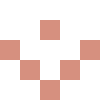

In [20]:
make_identicon("46098475")

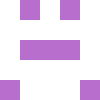

In [21]:
# 参考サイトのユーザID
## 同一の画像が生成されるか確認
make_identicon("19229051")

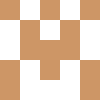

In [22]:
make_identicon("amenoyoya")

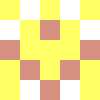

In [23]:
idimg = make_identicon("46098475")
nameimg = make_identicon("amenoyoya")

overlay(a::Float64, b::Float64)::Float64 =
    a < 0.5 ? a * b : 2 * (a + b - a * b) - 1.0

overlay(a::RGB{Float64}, b::RGB{Float64})::RGB{Float64} = RGB(
    overlay(a.r, b.r), overlay(a.g, b.g), overlay(a.b, b.b)
)

blend(a::RGB{Float64}, b::RGB{Float64})::RGB{Float64} = RGB(a.r * b.r, a.g * b.g, a.b * b.b)

overlay.(nameimg, idimg) |> a -> blend.(a, idimg)

# ドット絵変換処理

## ドット化

基本的に縮小すれば（低解像度化すれば）ドット絵っぽくはなる

## 減色

### k-means法
k-means法は、以下のような処理を、代表色が変化しなくなるまで繰り返す減色方法である

1. ランダムにN個の代表色を選択する
2. 画像のそれぞれのピクセルについて、一番近い代表色を選んで、全ピクセルをN個のグループに分割する
    - 色の近さは $(R_1 - R_2)^2 + (G_1 - G_2)^2 + (B_1 - B_2)^2$ という、3次元ベクトル空間上の距離で計算することができる
3. それぞれのグループの平均色（R, G, Bそれぞれの平均値を取った色）を新たな代表色とする
4. 新しい代表色を用いて、再度 2. の処理を行う

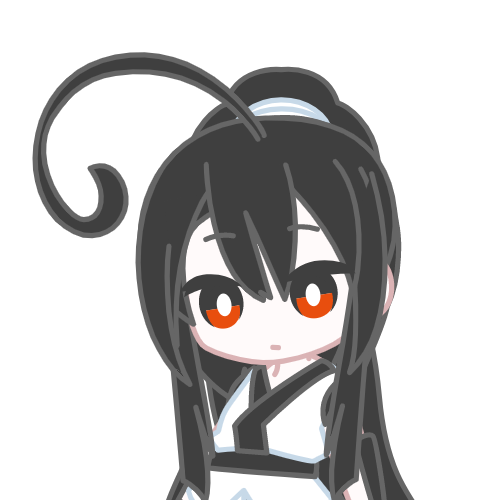

(500, 500)

In [24]:
using Images

img = load("./img/mono_20191110_face.png") # => Array{RGBA{N08f}}
display(img) # Images.jl パッケージを使っている場合 Array{RGBA{}} 形式の配列は画像として表示される
w, h = size(img)

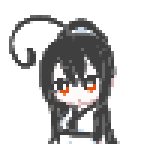

Array{RGBA{N0f8}}((48, 48))
  1: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UInt8 0x00
    b: N0f8
      i: UInt8 0x00
    alpha: N0f8
      i: UInt8 0x00
  2: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UInt8 0x00
    b: N0f8
      i: UInt8 0x00
    alpha: N0f8
      i: UInt8 0x00
  3: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UInt8 0x00
    b: N0f8
      i: UInt8 0x00
    alpha: N0f8
      i: UInt8 0x00
  4: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UInt8 0x00
    b: N0f8
      i: UInt8 0x00
    alpha: N0f8
      i: UInt8 0x00
  5: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UInt8 0x00
    b: N0f8
      i: UInt8 0x00
    alpha: N0f8
      i: UInt8 0x00
  ...
  2300: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UInt8 0x00
    b: N0f8
      i: UInt8 0x00
    alpha: N0f8
      i: UInt8 0x00
  2301: RGBA{N0f8}
    r: N0f8
      i: UInt8 0x00
    g: N0f8
      i: UIn

In [25]:
"""
48 x 48 ビット絵に変換する
"""
# 48 x 48 に縮小
dot = imresize(img, (48, 48))
display(dot)
dump(dot)

In [26]:
map = fill(0, 48, 48)
pallet = []

# ドット絵をマッピング
for y in 1:size(dot, 1)
    for x in 1:size(dot, 2)
        indexes = findall(pallet .== dot[x, y])
        map[x, y] = if length(indexes) === 0
            push!(pallet, dot[x, y])
            length(pallet)
        else
            indexes[1]
        end
    end
end

map

48×48 Matrix{Int64}:
 1  1  1  1  1   1   1   1  1  1   1  1  …    1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1   1   1  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1   1   1  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1   1   1  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1   1   1  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1   1   1  1  1  21  3  …    1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1   1  15  3  5   5  5       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   1  12   5  5  3  22  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1  10   5   3  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  1   5   3   1  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  1  3   3   1   1  1  1   1  1  …    1    1  1  1  1  1  1  1  1  1
 1  1  1  1  5   1   1   1  1  1   1  1       1    1  1  1  1  1  1  1  1  1
 1  1  1  2  3   1   1   1  1  1   1  1       1    1  1

In [27]:
pallet

154-element Vector{Any}:
 RGBA{N0f8}(0.0,0.0,0.0,0.0)
 RGBA{N0f8}(0.38,0.38,0.38,0.765)
 RGBA{N0f8}(0.4,0.4,0.4,1.0)
 RGBA{N0f8}(0.4,0.4,0.4,0.992)
 RGBA{N0f8}(0.247,0.247,0.247,1.0)
 RGBA{N0f8}(0.333,0.333,0.333,0.62)
 RGBA{N0f8}(0.255,0.255,0.255,0.188)
 RGBA{N0f8}(0.4,0.4,0.4,0.722)
 RGBA{N0f8}(0.259,0.259,0.259,1.0)
 RGBA{N0f8}(0.4,0.4,0.4,0.863)
 RGBA{N0f8}(0.169,0.169,0.169,0.129)
 RGBA{N0f8}(0.4,0.4,0.4,0.847)
 RGBA{N0f8}(0.271,0.271,0.271,1.0)
 ⋮
 RGBA{N0f8}(0.4,0.4,0.4,0.431)
 RGBA{N0f8}(0.357,0.357,0.357,1.0)
 RGBA{N0f8}(0.282,0.282,0.282,1.0)
 RGBA{N0f8}(0.388,0.388,0.388,0.875)
 RGBA{N0f8}(0.075,0.075,0.075,0.024)
 RGBA{N0f8}(0.361,0.361,0.361,1.0)
 RGBA{N0f8}(0.18,0.18,0.18,0.306)
 RGBA{N0f8}(0.404,0.404,0.404,0.596)
 RGBA{N0f8}(0.184,0.184,0.184,0.459)
 RGBA{N0f8}(0.188,0.188,0.188,0.106)
 RGBA{N0f8}(0.082,0.082,0.082,0.067)
 RGBA{N0f8}(0.392,0.392,0.392,0.384)

上記のように 154色あるので、16色になるまで k-means法で減色する

In [28]:
# まず 154-Vector{RGBA{}} を 154-Vector{4-Vector{Float32}} に変換
img_data = [[rgba.r, rgba.b, rgba.g, rgba.alpha] for rgba in pallet]

154-element Vector{Vector{N0f8}}:
 [0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8]
 [0.38N0f8, 0.38N0f8, 0.38N0f8, 0.765N0f8]
 [0.4N0f8, 0.4N0f8, 0.4N0f8, 1.0N0f8]
 [0.4N0f8, 0.4N0f8, 0.4N0f8, 0.992N0f8]
 [0.247N0f8, 0.247N0f8, 0.247N0f8, 1.0N0f8]
 [0.333N0f8, 0.333N0f8, 0.333N0f8, 0.62N0f8]
 [0.255N0f8, 0.255N0f8, 0.255N0f8, 0.188N0f8]
 [0.4N0f8, 0.4N0f8, 0.4N0f8, 0.722N0f8]
 [0.259N0f8, 0.259N0f8, 0.259N0f8, 1.0N0f8]
 [0.4N0f8, 0.4N0f8, 0.4N0f8, 0.863N0f8]
 [0.169N0f8, 0.169N0f8, 0.169N0f8, 0.129N0f8]
 [0.4N0f8, 0.4N0f8, 0.4N0f8, 0.847N0f8]
 [0.271N0f8, 0.271N0f8, 0.271N0f8, 1.0N0f8]
 ⋮
 [0.4N0f8, 0.4N0f8, 0.4N0f8, 0.431N0f8]
 [0.357N0f8, 0.357N0f8, 0.357N0f8, 1.0N0f8]
 [0.282N0f8, 0.282N0f8, 0.282N0f8, 1.0N0f8]
 [0.388N0f8, 0.388N0f8, 0.388N0f8, 0.875N0f8]
 [0.075N0f8, 0.075N0f8, 0.075N0f8, 0.024N0f8]
 [0.361N0f8, 0.361N0f8, 0.361N0f8, 1.0N0f8]
 [0.18N0f8, 0.18N0f8, 0.18N0f8, 0.306N0f8]
 [0.404N0f8, 0.404N0f8, 0.404N0f8, 0.596N0f8]
 [0.184N0f8, 0.184N0f8, 0.184N0f8, 0.459N0f8]
 [0.188N0f8, 0.1

In [29]:
using Statistics # mean, max, min 等の統計関連標準パッケージ
using LinearAlgebra # 行列演算関連の標準パッケージ

# 154色の画像を16色に減色
## => 154個のクラスタを16個のクラスタに分類
n_clusters = 16

# 画像データを n_clusters 数の所属クラスタにランダムに振る
clusters = rand(1:n_clusters, size(img_data))

154-element Vector{Int64}:
  9
 16
  3
 11
 16
 14
  4
  5
 14
  8
  9
 11
 10
  ⋮
  1
 13
 15
  3
 10
  1
  2
  7
  8
 13
 15
 15

In [30]:
# -- 各クラスタごとの中心点（代表色）の計算

# index: 1 に所属する画素を取得し行列に変換
## n-Vector{4-Vector{Float32}} => 4 x n - Matrix{Float32}
hcat(img_data[clusters .== 1]...)

4×10 Array{N0f8,2} with eltype N0f8:
 0.267  0.055  0.376  0.047  0.341  0.392  0.4    0.525  0.4    0.361
 0.267  0.055  0.376  0.047  0.341  0.392  0.4    0.525  0.4    0.361
 0.267  0.055  0.376  0.047  0.341  0.392  0.4    0.525  0.4    0.361
 1.0    0.016  1.0    0.031  1.0    1.0    0.706  1.0    0.431  1.0

In [31]:
# index: 1 に所属する画素の RGBA ごとの平均値を計算: 行ごとの平均値を取得
## 平均値を計算する際に Float32 に変換されてしまうため N0F8 型に戻す
n0f8.(mean(hcat(img_data[clusters .== 1]...); dims=2))

4×1 Array{N0f8,2} with eltype N0f8:
 0.318N0f8
 0.318N0f8
 0.318N0f8
 0.718N0f8

In [32]:
# 各クラスタごとの中心点（代表色＝画素ごとの平均値）の計算
centroids = [vcat(n0f8.(mean(hcat(img_data[clusters .== n]...); dims=2))...) for n = 1:n_clusters]

16-element Vector{Vector{N0f8}}:
 [0.318N0f8, 0.318N0f8, 0.318N0f8, 0.718N0f8]
 [0.404N0f8, 0.404N0f8, 0.404N0f8, 0.78N0f8]
 [0.4N0f8, 0.404N0f8, 0.4N0f8, 0.937N0f8]
 [0.49N0f8, 0.439N0f8, 0.451N0f8, 0.878N0f8]
 [0.635N0f8, 0.533N0f8, 0.557N0f8, 0.875N0f8]
 [0.486N0f8, 0.494N0f8, 0.49N0f8, 0.929N0f8]
 [0.263N0f8, 0.263N0f8, 0.263N0f8, 0.388N0f8]
 [0.6N0f8, 0.553N0f8, 0.561N0f8, 0.914N0f8]
 [0.502N0f8, 0.502N0f8, 0.502N0f8, 0.702N0f8]
 [0.525N0f8, 0.49N0f8, 0.486N0f8, 0.902N0f8]
 [0.416N0f8, 0.4N0f8, 0.4N0f8, 0.812N0f8]
 [0.384N0f8, 0.384N0f8, 0.384N0f8, 0.718N0f8]
 [0.592N0f8, 0.518N0f8, 0.537N0f8, 0.82N0f8]
 [0.412N0f8, 0.416N0f8, 0.412N0f8, 0.918N0f8]
 [0.337N0f8, 0.333N0f8, 0.333N0f8, 0.624N0f8]
 [0.643N0f8, 0.667N0f8, 0.647N0f8, 0.973N0f8]

In [33]:
# 上記コードは、所属されているデータが一つもないクラスタもありえる
clusters = fill(1, 154) # 例えばすべてのデータが 1 のクラスタに所属している場合
n0f8.(mean(hcat(img_data[clusters .== 2]...); dims=2)) # 2 のクラスタに所属している画素データの平均値が求められない

LoadError: MethodError: no method matching zero(::Type{Any})
[0mClosest candidates are:
[0m  zero(::Type{Union{Missing, T}}) where T at missing.jl:105
[0m  zero([91m::Union{Type{P}, P}[39m) where P<:Dates.Period at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Dates/src/periods.jl:53
[0m  zero([91m::FixedPoint[39m) at /home/user/.julia/packages/FixedPointNumbers/HAGk2/src/FixedPointNumbers.jl:222
[0m  ...

In [34]:
# 上記の問題を解決するためには、欠損クラスタでは任意画素を代表値とすれば良い
let vec = img_data[clusters .== 2]
    if length(vec) === 0
        hcat([img_data[rand(1:size(img_data)[1])]...])
    else
        n0f8.(mean(hcat(vec...); dims=2))
    end
end

4×1 Array{N0f8,2} with eltype N0f8:
 0.082N0f8
 0.082N0f8
 0.082N0f8
 0.102N0f8

In [35]:
# 各クラスタごとの中心点（代表色＝画素ごとの平均値）の計算（改善版）
centroids = [
    vcat(
        let vec = img_data[clusters .== n]
            if length(vec) === 0
                hcat([img_data[rand(1:size(img_data)[1])]...])
            else
                n0f8.(mean(hcat(vec...); dims=2))
            end
        end
    ) for n = 1:n_clusters
]

16-element Vector{Matrix{N0f8}}:
 [0.482N0f8; 0.459N0f8; 0.463N0f8; 0.835N0f8]
 [0.169N0f8; 0.169N0f8; 0.169N0f8; 0.129N0f8]
 [0.412N0f8; 0.416N0f8; 0.416N0f8; 1.0N0f8]
 [0.325N0f8; 0.325N0f8; 0.325N0f8; 1.0N0f8]
 [0.4N0f8; 0.4N0f8; 0.4N0f8; 0.91N0f8]
 [0.455N0f8; 0.506N0f8; 0.482N0f8; 1.0N0f8]
 [0.988N0f8; 0.996N0f8; 0.992N0f8; 1.0N0f8]
 [0.38N0f8; 0.38N0f8; 0.38N0f8; 1.0N0f8]
 [0.4N0f8; 0.4N0f8; 0.4N0f8; 0.992N0f8]
 [0.404N0f8; 0.404N0f8; 0.404N0f8; 1.0N0f8]
 [0.412N0f8; 0.416N0f8; 0.416N0f8; 1.0N0f8]
 [0.278N0f8; 0.282N0f8; 0.282N0f8; 1.0N0f8]
 [0.11N0f8; 0.11N0f8; 0.11N0f8; 0.02N0f8]
 [0.808N0f8; 0.792N0f8; 0.792N0f8; 1.0N0f8]
 [0.522N0f8; 0.522N0f8; 0.522N0f8; 1.0N0f8]
 [0.506N0f8; 0.502N0f8; 0.502N0f8; 1.0N0f8]

In [36]:
# img_data[1] (RGBA::4-Vector{Float32}) が 16個のクラスタのどこに近いか確認
## (R_1 - R_2)^2 + (G_1 - G_2)^2 + (B_1 - B_2)^2 を各代表色ごとに計算
[sum((img_data[1] - c).^2) for c in centroids]

16-element Vector{Float64}:
 0.8901960784313726
 2.8588235294117643
 1.0392156862745097
 1.3764705882352941
 1.1019607843137254
 0.8196078431372549
 0.0
 1.1647058823529413
 1.0941176470588234
 1.0823529411764705
 1.0392156862745097
 1.5686274509803924
 3.3686274509803926
 0.12549019607843137
 0.6941176470588235
 0.7490196078431373

In [37]:
# (R_1 - R_2)^2 + (G_1 - G_2)^2 + (B_1 - B_2)^2 が最小の index が所属するクラスタになる
value, index = findmin([sum((img_data[1] - c).^2) for c in centroids])

(0.0, 7)

In [38]:
# img_data[1:154] に対して、それぞれの画素が 16個のクラスタ（代表色）のどこに所属するか決める
new_clusters = Vector{Int}(undef, size(img_data)[1])
for i = 1:size(img_data)[1]
    _, index = findmin([sum((img_data[i] - c).^2) for c in centroids])
    new_clusters[i] = index
end

new_clusters

154-element Vector{Int64}:
  7
  2
  8
  9
  7
  2
  2
  2
  7
  2
  2
  2
  7
  ⋮
  8
  4
 12
  2
  7
  4
  2
  8
  2
 13
  7
  8

In [39]:
"""
k-meansによる分類
    kmeans(data::Vector{}, n_clasters::Int; max_iter::Int = 1000)
        -> ::Tuple{clusters :: size(data)[1]-Vector{Int}, centroids :: 4 x n_clusters-Matrix{Float32}
"""
kmeans = (data, n_clusters; max_iter = 1000) -> begin
    # 画像データを n_clusters 数の所属クラスタにランダムに振る
    clusters = rand(1:n_clusters, size(data))
    
    # 各クラスたごとの中心点（代表色）
    centroids = []
    
    for i = 1:max_iter
        # 各クラスタごとの中心点（代表色＝画素ごとの平均値）の計算
        centroids = [
            vcat(
                let vec = img_data[clusters .== n]
                    if length(vec) === 0
                        hcat([img_data[rand(1:size(img_data)[1])]...]) # 欠損クラスタではランダムな画素を中心点とする
                    else
                        n0f8.(mean(hcat(vec...); dims=2)) # 該当クラスタに所属している画素の平均値を計算
                    end
                end
            ) for n = 1:n_clusters
        ]

        # data[1:end] それぞれの値が n_clusters 個のクラスタ（代表色）のどこに所属するか決める
        new_clusters = Vector{Int}(undef, size(data)[1])
        for i = 1:size(data)[1]
            distances = [sum((data[i] - c).^2) for c in centroids]
            _, index = findmin(distances)
            new_clusters[i] = index
        end

        # 収束判定（クラスタの所属が変化しなくなった時点で終了）
        if all(clusters .== new_clusters)
            break
        end

        clusters = new_clusters
    end
    # 所属クラスタと中心点（代表色）を返す
    return (clusters, centroids)
end

# 154色の画像を16色に減色（154個のクラスタを16個のクラスタに分類）
clusters, centroids = kmeans(img_data, 16)

([13, 6, 3, 3, 13, 6, 13, 7, 13, 9  …  13, 6, 13, 6, 13, 2, 13, 13, 13, 6], Matrix{N0f8}[[0.404N0f8; 0.404N0f8; 0.404N0f8; 0.745N0f8], [0.404N0f8; 0.404N0f8; 0.404N0f8; 0.596N0f8], [0.392N0f8; 0.392N0f8; 0.392N0f8; 0.925N0f8], [0.361N0f8; 0.361N0f8; 0.361N0f8; 0.898N0f8], [0.933N0f8; 0.302N0f8; 0.49N0f8; 1.0N0f8], [0.325N0f8; 0.325N0f8; 0.325N0f8; 1.0N0f8], [0.4N0f8; 0.4N0f8; 0.4N0f8; 0.714N0f8], [0.4N0f8; 0.404N0f8; 0.4N0f8; 0.875N0f8], [0.4N0f8; 0.4N0f8; 0.4N0f8; 0.725N0f8], [0.784N0f8; 0.784N0f8; 0.769N0f8; 1.0N0f8], [0.427N0f8; 0.396N0f8; 0.404N0f8; 0.698N0f8], [0.459N0f8; 0.455N0f8; 0.451N0f8; 1.0N0f8], [0.914N0f8; 0.788N0f8; 0.792N0f8; 1.0N0f8], [0.514N0f8; 0.518N0f8; 0.518N0f8; 1.0N0f8], [0.655N0f8; 0.671N0f8; 0.647N0f8; 1.0N0f8], [0.584N0f8; 0.58N0f8; 0.58N0f8; 1.0N0f8]])

In [40]:
# -- 元絵の (1, 1) 画素を 154カテゴリ（154色）=> 16カテゴリ（16色）に変換 

# 元絵の (1, 1) 画素を 154カテゴリ（154色）のどれに所属するか判定
findall(data -> data[1] == dot[1, 1].r && data[2] == dot[1, 1].g && data[3] == dot[1, 1].b && data[4] == dot[1, 1].alpha, img_data)

1-element Vector{Int64}:
 1

In [41]:
# 元絵の (1, 1) 画素を 154カテゴリ => 16カテゴリにマッピングし、該当の色（代表色）を取得
index = clusters[
    findall(data -> data[1] == dot[1, 1].r && data[2] == dot[1, 1].g && data[3] == dot[1, 1].b && data[4] == dot[1, 1].alpha, img_data)
]
color = centroids[index][1]

4×1 Array{N0f8,2} with eltype N0f8:
 0.914N0f8
 0.788N0f8
 0.792N0f8
 1.0N0f8

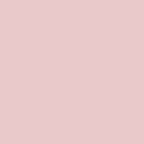

In [42]:
# 元絵の画像データを16色に減色した状態に変換
sub_img_data = zeros(RGBA{Float32}, size(dot, 1), size(dot, 2))

for y in 1:size(dot, 1)
    for x in 1:size(dot, 2)
        index = clusters[
            findall(data -> data[1] == dot[1, 1].r && data[2] == dot[1, 1].g && data[3] == dot[1, 1].b && data[4] == dot[1, 1].alpha, img_data)
        ]
        color = centroids[index][1]
        sub_img_data[y, x] = RGBA(color[1], color[2], color[3], color[4])
    end
end

display(sub_img_data)

上記の通り、真っ白な画像になってしまい、上手く k-means 法による減色ができていない